# Creating New Variables

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import hiplot as hip

In [2]:
sns.set_style("whitegrid")
sns.axes_style({'axes.grid': True, 'xtick.bottom': True,})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
tenure = pd.read_csv("../../../Final/Tenure_Multi_Elo_Models_with_Elos.csv")

## 1. Create pre-season elos for BM2

In [4]:
elo = pd.read_csv("season_elos_name_bm2.csv")

id_lookup = 1002
season_elos_lookup = 1500
pre_season_elo_bm2 = []
for x in elo.itertuples():
    id_new=x.team_id
    elo_new=x.season_elo_bm2
    if id_new == id_lookup:
        pre_season_elo_bm2s = season_elos_lookup
        
    else:
        pre_season_elo_bm2s = 1500
        
    season_elos_lookup = elo_new
    id_lookup = id_new
    pre_season_elo_bm2.append(pre_season_elo_bm2s)

elo['pre_season_elo_bm2']=pre_season_elo_bm2

bm2 = elo[['year-team','pre_season_elo_bm2']]
bm2_nodup = bm2.drop_duplicates(subset=['year-team'])
tenure_bm2 = pd.merge(tenure, bm2_nodup, on ='year-team', how = 'left')

#Change NFL, pro team Elo to 3500
tenure_bm2.loc[tenure_bm2.d_nfl ==1, 'pre_season_elo_bm2']=3500
tenure_bm2.loc[tenure_bm2.d_nfl ==1, 'season_elo_bm2']=3500

# tenure_bm2.loc[tenure_bm2.d_pro_team ==1, 'pre_season_elo_bm2']=3500
# tenure_bm2.loc[tenure_bm2.d_pro_team ==1, 'season_elo_bm2']=3500

# #Change HS, JC and missing teams Elo to 500
# tenure_bm2.loc[tenure_bm2.d_missing_info ==1, 'pre_season_elo_bm2']=500
# tenure_bm2.loc[tenure_bm2.d_missing_info ==1, 'season_elo_bm2']=500

tenure_bm2.loc[tenure_bm2.d_hs_cc_jc ==1, 'pre_season_elo_bm2']=500
tenure_bm2.loc[tenure_bm2.d_hs_cc_jc ==1, 'season_elo_bm2']=500

#Change pre-official team to 1500
tenure_bm2.loc[tenure_bm2.d_pre_official ==1, 'pre_season_elo_bm2']=1500
tenure_bm2.loc[tenure_bm2.d_pre_official ==1, 'season_elo_bm2']=1500

In [5]:
tenure.shape

(10151, 61)

In [6]:
tenure_bm2.shape


(10151, 62)

## 2. Create pre-coach elo BM2

In [7]:
id_coach_lookup = "Nick Saban"
season_elos_lookup = np.NaN
pre_coach_elo_bm2 = []
for x in tenure_bm2.itertuples():
    id_new=x.name
    elo_new=x.season_elo_bm2
    if id_new == id_coach_lookup:
        pre_coach_elo_bm2s = season_elos_lookup
        
    else:
        pre_coach_elo_bm2s = np.NaN
        
    season_elos_lookup = elo_new
    id_coach_lookup = id_new
    pre_coach_elo_bm2.append(pre_coach_elo_bm2s)

tenure_bm2['pre_coach_elo_bm2']=pre_coach_elo_bm2

## 3. Create position change var

In [8]:
tenure_bm2['pos_diff_bm2'] = tenure_bm2.groupby(['name'])['highest_position_code'].diff()
tenure_bm2['pos_diff_bm2_neg'] = - tenure_bm2['pos_diff_bm2']
tenure

## 4. Create dummy for team change


In [9]:
id_team_lookup = "Kent State University at Kent"
id_coach_lookup = "Nick Saban"
team_changes = []
for x in tenure_bm2.itertuples():
    id_new_team=x.school_name
    id_new_coach=x.name
    if id_new_team == id_team_lookup:
        team_change = 0
    elif id_new_coach!=id_coach_lookup:
        team_change = 0
    else:
        team_change = 1
    id_coach_lookup = id_new_coach
    id_team_lookup = id_new_team
    team_changes.append(team_change)

tenure_bm2['team_change']=team_changes

## 5. Create tenure var


In [10]:
year_lookup = 1
name_lookup = 'x'
tenure_durations = []
for x in tenure_bm2.itertuples():
    if x.name !=name_lookup:
        tenure_duration = 1
        year_lookup = x.year
        name_lookup = x.name
    else:
        tenure_duration = x.year - year_lookup +1
    
    tenure_durations.append(tenure_duration)
tenure_bm2['tenure_duration'] =   tenure_durations  

## 6. Create new college change var


In [11]:
tenure_bm2.loc[(tenure_bm2["team_change"]==1) & (tenure_bm2["pre_coach_elo_bm2"].notnull()) 
               & (tenure_bm2["pre_season_elo_bm2"].notnull())
               &  (tenure_bm2["pre_coach_elo_bm2"]!=0.)
               &(tenure_bm2["pos_diff_bm2"].notnull()), 
                   "college_nfl_hs_change"] = "x"

## 7. Create Elo gains, percentage gains var


In [12]:
#Create Percentage
tenure_bm2['elo_gains_bm2'] = tenure_bm2['pre_season_elo_bm2'] - tenure_bm2['pre_coach_elo_bm2']

tenure_bm2['percentage_elo_gain_bm2'] = tenure_bm2['elo_gains_bm2']/tenure_bm2['pre_coach_elo_bm2']*100


In [13]:
#First job elo and position
first_job_elo =[]
first_job_pos =[]
name=0
m=0
n=0
for i in tenure_bm2.itertuples():
    if i.name!=name:
        m=i.pre_season_elo_bm2
        n=i.highest_position_code
        name=i.name
    else:
        m=m
        n=n
    first_job_elo.append(m)
    first_job_pos.append(n)
tenure_bm2["first_job_elo"]  =first_job_elo
tenure_bm2["first_job_pos"]  =first_job_pos

# ##Need to add Elo for non-college teams

In [14]:
#Create movement dummies
#up-up
tenure_bm2.loc[(tenure_bm2.pos_diff_bm2_neg>0) & (tenure_bm2.percentage_elo_gain_bm2 >3)
               & (tenure_bm2.college_nfl_hs_change=='x'), "h_r_uu"]=1
tenure_bm2.h_r_uu=tenure_bm2.h_r_uu.fillna(0)

#up-down
tenure_bm2.loc[(tenure_bm2.pos_diff_bm2_neg>0) & (tenure_bm2.percentage_elo_gain_bm2 <-3)& (tenure_bm2.college_nfl_hs_change=='x'), "h_r_ud"]=1
tenure_bm2.h_r_ud=tenure_bm2.h_r_ud.fillna(0)
#up-non
tenure_bm2.loc[(tenure_bm2.pos_diff_bm2_neg>0) & (tenure_bm2.percentage_elo_gain_bm2>=-3) &
                   (tenure_bm2.percentage_elo_gain_bm2<=3)& (tenure_bm2.college_nfl_hs_change=='x'), "h_r_un"]=1
tenure_bm2.h_r_un=tenure_bm2.h_r_un.fillna(0)
#down-up
tenure_bm2.loc[(tenure_bm2.pos_diff_bm2_neg<0) & (tenure_bm2.percentage_elo_gain_bm2 >3)& (tenure_bm2.college_nfl_hs_change=='x'), "h_r_du"]=1
tenure_bm2.h_r_du=tenure_bm2.h_r_du.fillna(0)
#down-down
tenure_bm2.loc[(tenure_bm2.pos_diff_bm2_neg<0) & (tenure_bm2.percentage_elo_gain_bm2 <-3)& (tenure_bm2.college_nfl_hs_change=='x'), "h_r_dd"]=1
tenure_bm2.h_r_dd=tenure_bm2.h_r_dd.fillna(0)
#down-non
tenure_bm2.loc[(tenure_bm2.pos_diff_bm2_neg<0) & (tenure_bm2.percentage_elo_gain_bm2>=-3) &
                   (tenure_bm2.percentage_elo_gain_bm2<=3)& (tenure_bm2.college_nfl_hs_change=='x'), "h_r_dn"]=1
tenure_bm2.h_r_dn=tenure_bm2.h_r_dn.fillna(0)
#non-up
tenure_bm2.loc[(tenure_bm2.pos_diff_bm2_neg==0) & (tenure_bm2.percentage_elo_gain_bm2 >3)& (tenure_bm2.college_nfl_hs_change=='x'), "h_r_nu"]=1
tenure_bm2.h_r_nu=tenure_bm2.h_r_nu.fillna(0)

#non-down
tenure_bm2.loc[(tenure_bm2.pos_diff_bm2_neg==0) & (tenure_bm2.percentage_elo_gain_bm2 <-3)& (tenure_bm2.college_nfl_hs_change=='x'), "h_r_nd"]=1
tenure_bm2.h_r_nd=tenure_bm2.h_r_nd.fillna(0)
#non-non
tenure_bm2.loc[(tenure_bm2.pos_diff_bm2_neg==0) & (tenure_bm2.percentage_elo_gain_bm2>=-3) &
                   (tenure_bm2.percentage_elo_gain_bm2<=3)& (tenure_bm2.college_nfl_hs_change=='x'), "h_r_nn"]=1
tenure_bm2.h_r_nn=tenure_bm2.h_r_nn.fillna(0)

In [15]:
team_change_count=[]
k=0
name="x"
for i in tenure_bm2.itertuples():
    if i.name==name:
        if i.team_change==1:
            k=(k+1)
            
        else:
            k=k
    else:
        name=i.name
        k=0
    team_change_count.append(k)
tenure_bm2["team_change_count"]=team_change_count

### Calculate count and percentage of movements all years

In [16]:
#uu
h_r_uu_count=[]
avg_elo_gain_uu = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2.itertuples():
    if i.name==name:
        if i.h_r_uu==1:
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_uu_count.append(x)
    avg_elo_gain_uu.append(avg_elo_gain_type)    
tenure_bm2["h_r_uu_count"]=h_r_uu_count
tenure_bm2["avg_elo_gain_uu"]=avg_elo_gain_uu
tenure_bm2["h_r_uu_interact"]=tenure_bm2["h_r_uu_count"] * tenure_bm2["avg_elo_gain_uu"]

In [17]:
#nu
h_r_nu_count=[]
avg_elo_gain_nu = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2.itertuples():
    if i.name==name:
        if i.h_r_nu==1:
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nu_count.append(x)
    avg_elo_gain_nu.append(avg_elo_gain_type)    
tenure_bm2["h_r_nu_count"]=h_r_nu_count
tenure_bm2["avg_elo_gain_nu"]=avg_elo_gain_nu
tenure_bm2["h_r_nu_interact"]=tenure_bm2["h_r_nu_count"] * tenure_bm2["avg_elo_gain_nu"]

In [18]:
#du
h_r_du_count=[]
avg_elo_gain_du = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2.itertuples():
    if i.name==name:
        if i.h_r_du==1:
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_du_count.append(x)
    avg_elo_gain_du.append(avg_elo_gain_type)    
tenure_bm2["h_r_du_count"]=h_r_du_count
tenure_bm2["avg_elo_gain_du"]=avg_elo_gain_du
tenure_bm2["h_r_du_interact"]=tenure_bm2["h_r_du_count"] * tenure_bm2["avg_elo_gain_du"]

In [19]:
#ud
h_r_ud_count=[]
avg_elo_gain_ud = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2.itertuples():
    if i.name==name:
        if i.h_r_ud==1:
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_ud_count.append(x)
    avg_elo_gain_ud.append(avg_elo_gain_type)    
tenure_bm2["h_r_ud_count"]=h_r_ud_count
tenure_bm2["avg_elo_gain_ud"]=avg_elo_gain_ud
tenure_bm2["h_r_ud_interact"]=tenure_bm2["h_r_ud_count"] * tenure_bm2["avg_elo_gain_ud"]

In [20]:
#nd
h_r_nd_count=[]
avg_elo_gain_nd = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2.itertuples():
    if i.name==name:
        if i.h_r_nd==1:
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nd_count.append(x)
    avg_elo_gain_nd.append(avg_elo_gain_type)    
tenure_bm2["h_r_nd_count"]=h_r_nd_count
tenure_bm2["avg_elo_gain_nd"]=avg_elo_gain_nd
tenure_bm2["h_r_nd_interact"]=tenure_bm2["h_r_nd_count"] * tenure_bm2["avg_elo_gain_nd"]

In [21]:
#dd
h_r_dd_count=[]
avg_elo_gain_dd = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2.itertuples():
    if i.name==name:
        if i.h_r_dd==1:
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_dd_count.append(x)
    avg_elo_gain_dd.append(avg_elo_gain_type)    
tenure_bm2["h_r_dd_count"]=h_r_dd_count
tenure_bm2["avg_elo_gain_dd"]=avg_elo_gain_dd
tenure_bm2["h_r_dd_interact"]=tenure_bm2["h_r_dd_count"] * tenure_bm2["avg_elo_gain_dd"]

In [22]:
#un
h_r_un_count=[]
avg_elo_gain_un = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2.itertuples():
    if i.name==name:
        if i.h_r_un==1:
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_un_count.append(x)
    avg_elo_gain_un.append(avg_elo_gain_type)    
tenure_bm2["h_r_un_count"]=h_r_un_count
tenure_bm2["avg_elo_gain_un"]=avg_elo_gain_un
tenure_bm2["h_r_un_interact"]=tenure_bm2["h_r_un_count"] * tenure_bm2["avg_elo_gain_un"]

In [23]:
#nn
h_r_nn_count=[]
avg_elo_gain_nn = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2.itertuples():
    if i.name==name:
        if i.h_r_nn==1:
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nn_count.append(x)
    avg_elo_gain_nn.append(avg_elo_gain_type)    
tenure_bm2["h_r_nn_count"]=h_r_nn_count
tenure_bm2["avg_elo_gain_nn"]=avg_elo_gain_nn
tenure_bm2["h_r_nn_interact"]=tenure_bm2["h_r_nn_count"] * tenure_bm2["avg_elo_gain_nn"]

In [24]:
#dn
h_r_dn_count=[]
avg_elo_gain_dn = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2.itertuples():
    if i.name==name:
        if i.h_r_dn==1:
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_dn_count.append(x)
    avg_elo_gain_dn.append(avg_elo_gain_type)    
tenure_bm2["h_r_dn_count"]=h_r_dn_count
tenure_bm2["avg_elo_gain_dn"]=avg_elo_gain_dn
tenure_bm2["h_r_dn_interact"]=tenure_bm2["h_r_dn_count"] * tenure_bm2["avg_elo_gain_dn"]

In [25]:
# df_first_fbs_hc=tenure_bm2.loc[tenure_bm2.first_fbs_hc==1]
# sns.scatterplot(data=df_first_fbs_hc, x="h_r_ud_percent", y="tenure_duration")

In [26]:
# h_r_nn_percent=[]
# x=0
# y=0
# name="x"
# for i in tenure_bm2.itertuples():
#     if i.name==name:
#         if i.h_r_nn==1:
#             x=(x+1)
#             y=100*x/(max((i.team_change_count),1))
#         else:
#             y=100*x/(max((i.team_change_count),1))
#     else:
#         name=i.name
#         x=0
#         y=0
#     h_r_nn_percent.append(y)
# tenure_bm2["h_r_nn_percent"]=h_r_nn_percent

# h_r_nd_percent=[]
# x=0
# y=0
# name="x"
# for i in tenure_bm2.itertuples():
#     if i.name==name:
#         if i.h_r_nd==1:
#             x=(x+1)
#             y=100*x/(max((i.team_change_count),1))
#         else:
#             y=100*x/(max((i.team_change_count),1))
#     else:
#         name=i.name
#         x=0
#         y=0
#     h_r_nd_percent.append(y)
# tenure_bm2["h_r_nd_percent"]=h_r_nd_percent

# h_r_dd_percent=[]
# x=0
# y=0
# name="x"
# for i in tenure_bm2.itertuples():
#     if i.name==name:
#         if i.h_r_dd==1:
#             x=(x+1)
#             y=x*100/(max((i.team_change_count),1))
#         else:
#             y=x*100/(max((i.team_change_count),1))
#     else:
#         name=i.name
#         x=0
#         y=0
#     h_r_dd_percent.append(y)
# tenure_bm2["h_r_dd_percent"]=h_r_dd_percent

# h_r_nu_percent=[]
# x=0
# y=0
# name="x"
# for i in tenure_bm2.itertuples():
#     if i.name==name:
#         if i.h_r_nu==1:
#             x=(x+1)
#             y=100*x/(max((i.team_change_count),1))
#         else:
#             y=100*x/(max((i.team_change_count),1))
#     else:
#         name=i.name
#         x=0
#         y=0
#     h_r_nu_percent.append(y)
# tenure_bm2["h_r_nu_percent"]=h_r_nu_percent

# h_r_dn_percent=[]
# x=0
# y=0
# name="x"
# for i in tenure_bm2.itertuples():
#     if i.name==name:
#         if i.h_r_dn==1:
#             x=(x+1)
#             y=100*x/(max((i.team_change_count),1))
#         else:
#             y=100*x/(max((i.team_change_count),1))
#     else:
#         name=i.name
#         x=0
#         y=0
#     h_r_dn_percent.append(y)
# tenure_bm2["h_r_dn_percent"]=h_r_dn_percent

# h_r_du_percent=[]
# x=0
# y=0
# name="x"
# for i in tenure_bm2.itertuples():
#     if i.name==name:
#         if i.h_r_du==1:
#             x=(x+1)
#             y=x*100/(max((i.team_change_count),1))
#         else:
#             y=x*100/(max((i.team_change_count),1))
#     else:
#         name=i.name
#         x=0
#         y=0
#     h_r_du_percent.append(y)
# tenure_bm2["h_r_du_percent"]=h_r_du_percent

# h_r_ud_percent=[]
# x=0
# y=0
# name="x"
# for i in tenure_bm2.itertuples():
#     if i.name==name:
#         if i.h_r_ud==1:
#             x=(x+1)
#             y=100*x/(max((i.team_change_count),1))
#         else:
#             y=100*x/(max((i.team_change_count),1))
#     else:
#         name=i.name
#         x=0
#         y=0
#     h_r_ud_percent.append(y)
# tenure_bm2["h_r_ud_percent"]=h_r_ud_percent

# h_r_un_percent=[]
# x=0
# y=0
# name="x"
# for i in tenure_bm2.itertuples():
#     if i.name==name:
#         if i.h_r_un==1:
#             x=(x+1)
#             y=100*x/(max((i.team_change_count),1))
#         else:
#             y=100*x/(max((i.team_change_count),1))
#     else:
#         name=i.name
#         x=0
#         y=0
#     h_r_un_percent.append(y)
# tenure_bm2["h_r_un_percent"]=h_r_un_percent

# h_r_uu_percent=[]
# x=0
# y=0
# name="x"
# for i in tenure_bm2.itertuples():
#     if i.name==name:
#         if i.h_r_uu==1:
#             x=(x+1)
#             y=100*x/(max((i.team_change_count),1))
#         else:
#             y=100*x/(max((i.team_change_count),1))
#     else:
#         name=i.name
#         x=0
#         y=0
#     h_r_uu_percent.append(y)
# tenure_bm2["h_r_uu_percent"]=h_r_uu_percent

### Create variable indicates years after becoming HC for the first time & HC at FBS for the first time

In [27]:
#HC for first time
hc_first_times=[]
hc_first_time = 0

year_hc_first_times=[]
year_hc_first_time = 0

hc_name='x'


for i in tenure_bm2.itertuples():
    if (i.name != hc_name) and (i.highest_position_code ==1):
        hc_first_time = 1
        hc_name = i.name
        year_hc_first_time = i.year               
    else:
        hc_first_time = 0
        year_hc_first_time =0
    hc_first_times.append(hc_first_time)
    year_hc_first_times.append(year_hc_first_time)
    
tenure_bm2["hc_first_times"]=hc_first_times
tenure_bm2["year_hc_first_times"]=year_hc_first_times

bm2_year_hc_first_times = tenure_bm2.loc[tenure_bm2["hc_first_times"]==1, ['name','year_hc_first_times']]
tenure_bm2_drop = tenure_bm2.drop(columns=['year_hc_first_times'])

tenure_bm2_hc_first_time = pd.merge(tenure_bm2_drop, bm2_year_hc_first_times, on='name', how='left' )
    
    
    
#years after first HC
tenure_bm2_hc_first_time["years_after_first_hc"] = tenure_bm2_hc_first_time['year'] - tenure_bm2_hc_first_time['year_hc_first_times']

#create dummy for seasons after the first HC season
tenure_bm2_hc_first_time.loc[tenure_bm2_hc_first_time['years_after_first_hc']>0, 'after_first_hc'] = 1



### Calculate count and elo gains of years after being HC for the first time only

In [28]:
#uu
h_r_uu_count=[]
avg_elo_gain_uu = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_uu==1) and (i.after_first_hc==1):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_uu_count.append(x)
    avg_elo_gain_uu.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_uu_count_hc_first_time"]=h_r_uu_count
tenure_bm2_hc_first_time["avg_elo_gain_uu_hc_first_time"]=avg_elo_gain_uu
tenure_bm2_hc_first_time["h_r_uu_interact_hc_first_time"]=tenure_bm2_hc_first_time["h_r_uu_count_hc_first_time"] * tenure_bm2_hc_first_time["avg_elo_gain_uu_hc_first_time"]

#nu
h_r_nu_count=[]
avg_elo_gain_nu = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_nu==1) and (i.after_first_hc==1):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nu_count.append(x)
    avg_elo_gain_nu.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_nu_count_hc_first_time"]=h_r_nu_count
tenure_bm2_hc_first_time["avg_elo_gain_nu_hc_first_time"]=avg_elo_gain_nu
tenure_bm2_hc_first_time["h_r_nu_interact_hc_first_time"]=tenure_bm2_hc_first_time["h_r_nu_count_hc_first_time"] * tenure_bm2_hc_first_time["avg_elo_gain_nu_hc_first_time"]

#du
h_r_du_count=[]
avg_elo_gain_du = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_du==1) and (i.after_first_hc==1):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_du_count.append(x)
    avg_elo_gain_du.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_du_count_hc_first_time"]=h_r_du_count
tenure_bm2_hc_first_time["avg_elo_gain_du_hc_first_time"]=avg_elo_gain_du
tenure_bm2_hc_first_time["h_r_du_interact_hc_first_time"]=tenure_bm2_hc_first_time["h_r_du_count_hc_first_time"] * tenure_bm2_hc_first_time["avg_elo_gain_du_hc_first_time"]

#ud
h_r_ud_count=[]
avg_elo_gain_ud = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_ud==1) and (i.after_first_hc==1):
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_ud_count.append(x)
    avg_elo_gain_ud.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_ud_count_hc_first_time"]=h_r_ud_count
tenure_bm2_hc_first_time["avg_elo_gain_ud_hc_first_time"]=avg_elo_gain_ud
tenure_bm2_hc_first_time["h_r_ud_interact_hc_first_time"]=tenure_bm2_hc_first_time["h_r_ud_count_hc_first_time"] * tenure_bm2_hc_first_time["avg_elo_gain_ud_hc_first_time"]

#nd
h_r_nd_count=[]
avg_elo_gain_nd = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_nd==1) and (i.after_first_hc==1):
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nd_count.append(x)
    avg_elo_gain_nd.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_nd_count_hc_first_time"]=h_r_nd_count
tenure_bm2_hc_first_time["avg_elo_gain_nd_hc_first_time"]=avg_elo_gain_nd
tenure_bm2_hc_first_time["h_r_nd_interact_hc_first_time"]=tenure_bm2_hc_first_time["h_r_nd_count_hc_first_time"] * tenure_bm2_hc_first_time["avg_elo_gain_nd_hc_first_time"]

#dd
h_r_dd_count=[]
avg_elo_gain_dd = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_dd==1) and (i.after_first_hc==1):
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_dd_count.append(x)
    avg_elo_gain_dd.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_dd_count_hc_first_time"]=h_r_dd_count
tenure_bm2_hc_first_time["avg_elo_gain_dd_hc_first_time"]=avg_elo_gain_dd
tenure_bm2_hc_first_time["h_r_dd_interact_hc_first_time"]=tenure_bm2_hc_first_time["h_r_dd_count_hc_first_time"] * tenure_bm2_hc_first_time["avg_elo_gain_dd_hc_first_time"]

#un
h_r_un_count=[]
avg_elo_gain_un = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_un==1) and (i.after_first_hc==1):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_un_count.append(x)
    avg_elo_gain_un.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_un_count_hc_first_time"]=h_r_un_count
tenure_bm2_hc_first_time["avg_elo_gain_un_hc_first_time"]=avg_elo_gain_un
tenure_bm2_hc_first_time["h_r_un_interact_hc_first_time"]=tenure_bm2_hc_first_time["h_r_un_count_hc_first_time"] * tenure_bm2_hc_first_time["avg_elo_gain_un_hc_first_time"]

#nn
h_r_nn_count=[]
avg_elo_gain_nn = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_nn==1) and (i.after_first_hc==1):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nn_count.append(x)
    avg_elo_gain_nn.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_nn_count_hc_first_time"]=h_r_nn_count
tenure_bm2_hc_first_time["avg_elo_gain_nn_hc_first_time"]=avg_elo_gain_nn
tenure_bm2_hc_first_time["h_r_nn_interact_hc_first_time"]=tenure_bm2_hc_first_time["h_r_nn_count_hc_first_time"] * tenure_bm2_hc_first_time["avg_elo_gain_nn_hc_first_time"]

#dn
h_r_dn_count=[]
avg_elo_gain_dn = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_dn==1) and (i.after_first_hc==1):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_dn_count.append(x)
    avg_elo_gain_dn.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_dn_count_hc_first_time"]=h_r_dn_count
tenure_bm2_hc_first_time["avg_elo_gain_dn_hc_first_time"]=avg_elo_gain_dn
tenure_bm2_hc_first_time["h_r_dn_interact_hc_first_time"]=tenure_bm2_hc_first_time["h_r_dn_count_hc_first_time"] * tenure_bm2_hc_first_time["avg_elo_gain_dn_hc_first_time"]

### Calculate count and elo gains of years after first 3/5/7 years

In [29]:
##3 years
#uu
h_r_uu_count=[]
avg_elo_gain_uu = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_uu==1) and (i.tenure_duration>3):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_uu_count.append(x)
    avg_elo_gain_uu.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_uu_count_after_3y"]=h_r_uu_count
tenure_bm2_hc_first_time["avg_elo_gain_uu_after_3y"]=avg_elo_gain_uu
tenure_bm2_hc_first_time["h_r_uu_interact_after_3y"]=tenure_bm2_hc_first_time["h_r_uu_count_after_3y"] * tenure_bm2_hc_first_time["avg_elo_gain_uu_after_3y"]

#nu
h_r_nu_count=[]
avg_elo_gain_nu = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_nu==1) and (i.tenure_duration>3):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nu_count.append(x)
    avg_elo_gain_nu.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_nu_count_after_3y"]=h_r_nu_count
tenure_bm2_hc_first_time["avg_elo_gain_nu_after_3y"]=avg_elo_gain_nu
tenure_bm2_hc_first_time["h_r_nu_interact_after_3y"]=tenure_bm2_hc_first_time["h_r_nu_count_after_3y"] * tenure_bm2_hc_first_time["avg_elo_gain_nu_after_3y"]

#du
h_r_du_count=[]
avg_elo_gain_du = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_du==1) and (i.tenure_duration>3):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_du_count.append(x)
    avg_elo_gain_du.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_du_count_after_3y"]=h_r_du_count
tenure_bm2_hc_first_time["avg_elo_gain_du_after_3y"]=avg_elo_gain_du
tenure_bm2_hc_first_time["h_r_du_interact_after_3y"]=tenure_bm2_hc_first_time["h_r_du_count_after_3y"] * tenure_bm2_hc_first_time["avg_elo_gain_du_after_3y"]

#ud
h_r_ud_count=[]
avg_elo_gain_ud = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_ud==1) and (i.tenure_duration>3):
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_ud_count.append(x)
    avg_elo_gain_ud.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_ud_count_after_3y"]=h_r_ud_count
tenure_bm2_hc_first_time["avg_elo_gain_ud_after_3y"]=avg_elo_gain_ud
tenure_bm2_hc_first_time["h_r_ud_interact_after_3y"]=tenure_bm2_hc_first_time["h_r_ud_count_after_3y"] * tenure_bm2_hc_first_time["avg_elo_gain_ud_after_3y"]

#nd
h_r_nd_count=[]
avg_elo_gain_nd = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_nd==1) and (i.tenure_duration>3):
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nd_count.append(x)
    avg_elo_gain_nd.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_nd_count_after_3y"]=h_r_nd_count
tenure_bm2_hc_first_time["avg_elo_gain_nd_after_3y"]=avg_elo_gain_nd
tenure_bm2_hc_first_time["h_r_nd_interact_after_3y"]=tenure_bm2_hc_first_time["h_r_nd_count_after_3y"] * tenure_bm2_hc_first_time["avg_elo_gain_nd_after_3y"]

#dd
h_r_dd_count=[]
avg_elo_gain_dd = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_dd==1) and (i.tenure_duration>3):
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_dd_count.append(x)
    avg_elo_gain_dd.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_dd_count_after_3y"]=h_r_dd_count
tenure_bm2_hc_first_time["avg_elo_gain_dd_after_3y"]=avg_elo_gain_dd
tenure_bm2_hc_first_time["h_r_dd_interact_after_3y"]=tenure_bm2_hc_first_time["h_r_dd_count_after_3y"] * tenure_bm2_hc_first_time["avg_elo_gain_dd_after_3y"]

#un
h_r_un_count=[]
avg_elo_gain_un = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_un==1) and (i.tenure_duration>3):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_un_count.append(x)
    avg_elo_gain_un.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_un_count_after_3y"]=h_r_un_count
tenure_bm2_hc_first_time["avg_elo_gain_un_after_3y"]=avg_elo_gain_un
tenure_bm2_hc_first_time["h_r_un_interact_after_3y"]=tenure_bm2_hc_first_time["h_r_un_count_after_3y"] * tenure_bm2_hc_first_time["avg_elo_gain_un_after_3y"]

#nn
h_r_nn_count=[]
avg_elo_gain_nn = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_nn==1) and (i.tenure_duration>3):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nn_count.append(x)
    avg_elo_gain_nn.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_nn_count_after_3y"]=h_r_nn_count
tenure_bm2_hc_first_time["avg_elo_gain_nn_after_3y"]=avg_elo_gain_nn
tenure_bm2_hc_first_time["h_r_nn_interact_after_3y"]=tenure_bm2_hc_first_time["h_r_nn_count_after_3y"] * tenure_bm2_hc_first_time["avg_elo_gain_nn_after_3y"]

#dn
h_r_dn_count=[]
avg_elo_gain_dn = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_dn==1) and (i.tenure_duration>3):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_dn_count.append(x)
    avg_elo_gain_dn.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_dn_count_after_3y"]=h_r_dn_count
tenure_bm2_hc_first_time["avg_elo_gain_dn_after_3y"]=avg_elo_gain_dn
tenure_bm2_hc_first_time["h_r_dn_interact_after_3y"]=tenure_bm2_hc_first_time["h_r_dn_count_after_3y"] * tenure_bm2_hc_first_time["avg_elo_gain_dn_after_3y"]

In [30]:
##5 years
#uu
h_r_uu_count=[]
avg_elo_gain_uu = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_uu==1) and (i.tenure_duration>5):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_uu_count.append(x)
    avg_elo_gain_uu.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_uu_count_after_5y"]=h_r_uu_count
tenure_bm2_hc_first_time["avg_elo_gain_uu_after_5y"]=avg_elo_gain_uu
tenure_bm2_hc_first_time["h_r_uu_interact_after_5y"]=tenure_bm2_hc_first_time["h_r_uu_count_after_5y"] * tenure_bm2_hc_first_time["avg_elo_gain_uu_after_5y"]

#nu
h_r_nu_count=[]
avg_elo_gain_nu = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_nu==1) and (i.tenure_duration>5):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nu_count.append(x)
    avg_elo_gain_nu.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_nu_count_after_5y"]=h_r_nu_count
tenure_bm2_hc_first_time["avg_elo_gain_nu_after_5y"]=avg_elo_gain_nu
tenure_bm2_hc_first_time["h_r_nu_interact_after_5y"]=tenure_bm2_hc_first_time["h_r_nu_count_after_5y"] * tenure_bm2_hc_first_time["avg_elo_gain_nu_after_5y"]

#du
h_r_du_count=[]
avg_elo_gain_du = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_du==1) and (i.tenure_duration>5):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_du_count.append(x)
    avg_elo_gain_du.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_du_count_after_5y"]=h_r_du_count
tenure_bm2_hc_first_time["avg_elo_gain_du_after_5y"]=avg_elo_gain_du
tenure_bm2_hc_first_time["h_r_du_interact_after_5y"]=tenure_bm2_hc_first_time["h_r_du_count_after_5y"] * tenure_bm2_hc_first_time["avg_elo_gain_du_after_5y"]

#ud
h_r_ud_count=[]
avg_elo_gain_ud = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_ud==1) and (i.tenure_duration>5):
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_ud_count.append(x)
    avg_elo_gain_ud.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_ud_count_after_5y"]=h_r_ud_count
tenure_bm2_hc_first_time["avg_elo_gain_ud_after_5y"]=avg_elo_gain_ud
tenure_bm2_hc_first_time["h_r_ud_interact_after_5y"]=tenure_bm2_hc_first_time["h_r_ud_count_after_5y"] * tenure_bm2_hc_first_time["avg_elo_gain_ud_after_5y"]

#nd
h_r_nd_count=[]
avg_elo_gain_nd = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_nd==1) and (i.tenure_duration>5):
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nd_count.append(x)
    avg_elo_gain_nd.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_nd_count_after_5y"]=h_r_nd_count
tenure_bm2_hc_first_time["avg_elo_gain_nd_after_5y"]=avg_elo_gain_nd
tenure_bm2_hc_first_time["h_r_nd_interact_after_5y"]=tenure_bm2_hc_first_time["h_r_nd_count_after_5y"] * tenure_bm2_hc_first_time["avg_elo_gain_nd_after_5y"]

#dd
h_r_dd_count=[]
avg_elo_gain_dd = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_dd==1) and (i.tenure_duration>5):
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_dd_count.append(x)
    avg_elo_gain_dd.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_dd_count_after_5y"]=h_r_dd_count
tenure_bm2_hc_first_time["avg_elo_gain_dd_after_5y"]=avg_elo_gain_dd
tenure_bm2_hc_first_time["h_r_dd_interact_after_5y"]=tenure_bm2_hc_first_time["h_r_dd_count_after_5y"] * tenure_bm2_hc_first_time["avg_elo_gain_dd_after_5y"]

#un
h_r_un_count=[]
avg_elo_gain_un = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_un==1) and (i.tenure_duration>5):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_un_count.append(x)
    avg_elo_gain_un.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_un_count_after_5y"]=h_r_un_count
tenure_bm2_hc_first_time["avg_elo_gain_un_after_5y"]=avg_elo_gain_un
tenure_bm2_hc_first_time["h_r_un_interact_after_5y"]=tenure_bm2_hc_first_time["h_r_un_count_after_5y"] * tenure_bm2_hc_first_time["avg_elo_gain_un_after_5y"]

#nn
h_r_nn_count=[]
avg_elo_gain_nn = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_nn==1) and (i.tenure_duration>5):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nn_count.append(x)
    avg_elo_gain_nn.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_nn_count_after_5y"]=h_r_nn_count
tenure_bm2_hc_first_time["avg_elo_gain_nn_after_5y"]=avg_elo_gain_nn
tenure_bm2_hc_first_time["h_r_nn_interact_after_5y"]=tenure_bm2_hc_first_time["h_r_nn_count_after_5y"] * tenure_bm2_hc_first_time["avg_elo_gain_nn_after_5y"]

#dn
h_r_dn_count=[]
avg_elo_gain_dn = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_dn==1) and (i.tenure_duration>5):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_dn_count.append(x)
    avg_elo_gain_dn.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_dn_count_after_5y"]=h_r_dn_count
tenure_bm2_hc_first_time["avg_elo_gain_dn_after_5y"]=avg_elo_gain_dn
tenure_bm2_hc_first_time["h_r_dn_interact_after_5y"]=tenure_bm2_hc_first_time["h_r_dn_count_after_5y"] * tenure_bm2_hc_first_time["avg_elo_gain_dn_after_5y"]

In [31]:
##7 years
#uu
h_r_uu_count=[]
avg_elo_gain_uu = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_uu==1) and (i.tenure_duration>7):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_uu_count.append(x)
    avg_elo_gain_uu.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_uu_count_after_7y"]=h_r_uu_count
tenure_bm2_hc_first_time["avg_elo_gain_uu_after_7y"]=avg_elo_gain_uu
tenure_bm2_hc_first_time["h_r_uu_interact_after_7y"]=tenure_bm2_hc_first_time["h_r_uu_count_after_7y"] * tenure_bm2_hc_first_time["avg_elo_gain_uu_after_7y"]

#nu
h_r_nu_count=[]
avg_elo_gain_nu = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_nu==1) and (i.tenure_duration>7):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nu_count.append(x)
    avg_elo_gain_nu.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_nu_count_after_7y"]=h_r_nu_count
tenure_bm2_hc_first_time["avg_elo_gain_nu_after_7y"]=avg_elo_gain_nu
tenure_bm2_hc_first_time["h_r_nu_interact_after_7y"]=tenure_bm2_hc_first_time["h_r_nu_count_after_7y"] * tenure_bm2_hc_first_time["avg_elo_gain_nu_after_7y"]

#du
h_r_du_count=[]
avg_elo_gain_du = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_du==1) and (i.tenure_duration>7):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_du_count.append(x)
    avg_elo_gain_du.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_du_count_after_7y"]=h_r_du_count
tenure_bm2_hc_first_time["avg_elo_gain_du_after_7y"]=avg_elo_gain_du
tenure_bm2_hc_first_time["h_r_du_interact_after_7y"]=tenure_bm2_hc_first_time["h_r_du_count_after_7y"] * tenure_bm2_hc_first_time["avg_elo_gain_du_after_7y"]

#ud
h_r_ud_count=[]
avg_elo_gain_ud = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_ud==1) and (i.tenure_duration>7):
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_ud_count.append(x)
    avg_elo_gain_ud.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_ud_count_after_7y"]=h_r_ud_count
tenure_bm2_hc_first_time["avg_elo_gain_ud_after_7y"]=avg_elo_gain_ud
tenure_bm2_hc_first_time["h_r_ud_interact_after_7y"]=tenure_bm2_hc_first_time["h_r_ud_count_after_7y"] * tenure_bm2_hc_first_time["avg_elo_gain_ud_after_7y"]

#nd
h_r_nd_count=[]
avg_elo_gain_nd = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_nd==1) and (i.tenure_duration>7):
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nd_count.append(x)
    avg_elo_gain_nd.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_nd_count_after_7y"]=h_r_nd_count
tenure_bm2_hc_first_time["avg_elo_gain_nd_after_7y"]=avg_elo_gain_nd
tenure_bm2_hc_first_time["h_r_nd_interact_after_7y"]=tenure_bm2_hc_first_time["h_r_nd_count_after_7y"] * tenure_bm2_hc_first_time["avg_elo_gain_nd_after_7y"]

#dd
h_r_dd_count=[]
avg_elo_gain_dd = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_dd==1) and (i.tenure_duration>7):
            x=(x+1)
            avg_elo_gain_type = (-i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_dd_count.append(x)
    avg_elo_gain_dd.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_dd_count_after_7y"]=h_r_dd_count
tenure_bm2_hc_first_time["avg_elo_gain_dd_after_7y"]=avg_elo_gain_dd
tenure_bm2_hc_first_time["h_r_dd_interact_after_7y"]=tenure_bm2_hc_first_time["h_r_dd_count_after_7y"] * tenure_bm2_hc_first_time["avg_elo_gain_dd_after_7y"]

#un
h_r_un_count=[]
avg_elo_gain_un = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_un==1) and (i.tenure_duration>7):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_un_count.append(x)
    avg_elo_gain_un.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_un_count_after_7y"]=h_r_un_count
tenure_bm2_hc_first_time["avg_elo_gain_un_after_7y"]=avg_elo_gain_un
tenure_bm2_hc_first_time["h_r_un_interact_after_7y"]=tenure_bm2_hc_first_time["h_r_un_count_after_7y"] * tenure_bm2_hc_first_time["avg_elo_gain_un_after_7y"]

#nn
h_r_nn_count=[]
avg_elo_gain_nn = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_nn==1) and (i.tenure_duration>7):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_nn_count.append(x)
    avg_elo_gain_nn.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_nn_count_after_7y"]=h_r_nn_count
tenure_bm2_hc_first_time["avg_elo_gain_nn_after_7y"]=avg_elo_gain_nn
tenure_bm2_hc_first_time["h_r_nn_interact_after_7y"]=tenure_bm2_hc_first_time["h_r_nn_count_after_7y"] * tenure_bm2_hc_first_time["avg_elo_gain_nn_after_7y"]

#dn
h_r_dn_count=[]
avg_elo_gain_dn = []
x=0
avg_elo_gain_type=0
name="x"
for i in tenure_bm2_hc_first_time.itertuples():
    if i.name==name:
        if (i.h_r_dn==1) and (i.tenure_duration>7):
            x=(x+1)
            avg_elo_gain_type = (i.elo_gains_bm2+avg_elo_gain_type)/x
        else:
            x=x
            avg_elo_gain_type = avg_elo_gain_type
    else:
        name=i.name
        x=0
        avg_elo_gain_type = 0
    h_r_dn_count.append(x)
    avg_elo_gain_dn.append(avg_elo_gain_type)    
tenure_bm2_hc_first_time["h_r_dn_count_after_7y"]=h_r_dn_count
tenure_bm2_hc_first_time["avg_elo_gain_dn_after_7y"]=avg_elo_gain_dn
tenure_bm2_hc_first_time["h_r_dn_interact_after_7y"]=tenure_bm2_hc_first_time["h_r_dn_count_after_7y"] * tenure_bm2_hc_first_time["avg_elo_gain_dn_after_7y"]

In [32]:
tenure_bm2_hc_first_time.head(100)

,Unnamed: 0,idwiki_head_coach,name,year,school_name,fixed_name,team_code,conference,position,position_fixed,move_from_pro,d_hc_before,first_fbs_hc,highest_position_code,d_missing_info,d_pre_official,d_pro_team,d_nfl,d_hs_cc_jc,win,loss,ties,total,win_pct,bowl,ap_pre,ap_high,ap_post,unitid,dif_finish,playoffs,pf,pa,pd,coach,off_rank_pts,off_rank_yds,def_rank_pts,def_rank_yds,t_g,pts,yds,outof,mov,sos,srs,osrs,dsrs,season,team_id,year-team,season_elo_bm1,season_elo_bm2,season_elo_2_1,season_elo_2_2,season_elo_3_1,season_elo_3_2,season_elo_4_1,season_elo_4_2,season_elo_5_1,season_elo_5_2,pre_season_elo_bm2,pre_coach_elo_bm2,pos_diff_bm2,pos_diff_bm2_neg,team_change,tenure_duration,college_nfl_hs_change,elo_gains_bm2,percentage_elo_gain_bm2,first_job_elo,first_job_pos,h_r_uu,h_r_ud,h_r_un,h_r_du,h_r_dd,h_r_dn,h_r_nu,h_r_nd,h_r_nn,team_change_count,h_r_uu_count,avg_elo_gain_uu,h_r_uu_interact,h_r_nu_count,avg_elo_gain_nu,h_r_nu_interact,h_r_du_count,avg_elo_gain_du,h_r_du_interact,h_r_ud_count,avg_elo_gain_ud,h_r_ud_interact,h_r_nd_count,avg_elo_gain_nd,h_r_nd_interact,h_r_dd_count,avg_elo_gain_dd,h_r_dd_interact,h_r_un_count,avg_elo_gain_un,h_r_un_interact,h_r_nn_count,avg_elo_gain_nn,h_r_nn_interact,h_r_dn_count,avg_elo_gain_dn,h_r_dn_interact,hc_first_times,year_hc_first_times,years_after_first_hc,after_first_hc,h_r_uu_count_hc_first_time,avg_elo_gain_uu_hc_first_time,h_r_uu_interact_hc_first_time,h_r_nu_count_hc_first_time,avg_elo_gain_nu_hc_first_time,h_r_nu_interact_hc_first_time,h_r_du_count_hc_first_time,avg_elo_gain_du_hc_first_time,h_r_du_interact_hc_first_time,h_r_ud_count_hc_first_time,avg_elo_gain_ud_hc_first_time,h_r_ud_interact_hc_first_time,h_r_nd_count_hc_first_time,avg_elo_gain_nd_hc_first_time,h_r_nd_interact_hc_first_time,h_r_dd_count_hc_first_time,avg_elo_gain_dd_hc_first_time,h_r_dd_interact_hc_first_time,h_r_un_count_hc_first_time,avg_elo_gain_un_hc_first_time,h_r_un_interact_hc_first_time,h_r_nn_count_hc_first_time,avg_elo_gain_nn_hc_first_time,h_r_nn_interact_hc_first_time,h_r_dn_count_hc_first_time,avg_elo_gain_dn_hc_first_time,h_r_dn_interact_hc_first_time,h_r_uu_count_after_3y,avg_elo_gain_uu_after_3y,h_r_uu_interact_after_3y,h_r_nu_count_after_3y,avg_elo_gain_nu_after_3y,h_r_nu_interact_after_3y,h_r_du_count_after_3y,avg_elo_gain_du_after_3y,h_r_du_interact_after_3y,h_r_ud_count_after_3y,avg_elo_gain_ud_after_3y,h_r_ud_interact_after_3y,h_r_nd_count_after_3y,avg_elo_gain_nd_after_3y,h_r_nd_interact_after_3y,h_r_dd_count_after_3y,avg_elo_gain_dd_after_3y,h_r_dd_interact_after_3y,h_r_un_count_after_3y,avg_elo_gain_un_after_3y,h_r_un_interact_after_3y,h_r_nn_count_after_3y,avg_elo_gain_nn_after_3y,h_r_nn_interact_after_3y,h_r_dn_count_after_3y,avg_elo_gain_dn_after_3y,h_r_dn_interact_after_3y,h_r_uu_count_after_5y,avg_elo_gain_uu_after_5y,h_r_uu_interact_after_5y,h_r_nu_count_after_5y,avg_elo_gain_nu_after_5y,h_r_nu_interact_after_5y,h_r_du_count_after_5y,avg_elo_gain_du_after_5y,h_r_du_interact_after_5y,h_r_ud_count_after_5y,avg_elo_gain_ud_after_5y,h_r_ud_interact_after_5y,h_r_nd_count_after_5y,avg_elo_gain_nd_after_5y,h_r_nd_interact_after_5y,h_r_dd_count_after_5y,avg_elo_gain_dd_after_5y,h_r_dd_interact_after_5y,h_r_un_count_after_5y,avg_elo_gain_un_after_5y,h_r_un_interact_after_5y,h_r_nn_count_after_5y,avg_elo_gain_nn_after_5y,h_r_nn_interact_after_5y,h_r_dn_count_after_5y,avg_elo_gain_dn_after_5y,h_r_dn_interact_after_5y,h_r_uu_count_after_7y,avg_elo_gain_uu_after_7y,h_r_uu_interact_after_7y,h_r_nu_count_after_7y,avg_elo_gain_nu_after_7y,h_r_nu_interact_after_7y,h_r_du_count_after_7y,avg_elo_gain_du_after_7y,h_r_du_interact_after_7y,h_r_ud_count_after_7y,avg_elo_gain_ud_after_7y,h_r_ud_interact_after_7y,h_r_nd_count_after_7y,avg_elo_gain_nd_after_7y,h_r_nd_interact_after_7y,h_r_dd_count_after_7y,avg_elo_gain_dd_after_7y,h_r_dd_interact_after_7y,h_r_un_count_after_7y,avg_elo_gain_un_after_7y,h_r_un_interact_after_7y,h_r_nn_count_after_7y,avg_elo_gain_nn_after_7y,h_r_nn_interact_after_7y,h_r_dn_count_

## 8. Graphs

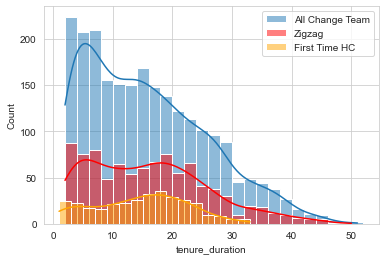

In [58]:
g1 = tenure_bm2_hc_first_time[(tenure_bm2_hc_first_time['h_r_ud']==1) | (tenure_bm2_hc_first_time['h_r_du']==1)]
g2 = tenure_bm2_hc_first_time[(tenure_bm2_hc_first_time['college_nfl_hs_change']=='x')]
g3 = tenure_bm2_hc_first_time[(tenure_bm2_hc_first_time['hc_first_times']==1)]
sns.histplot(g2['tenure_duration'], label='All Change Team', binwidth=2, kde=True)
sns.histplot(g1['tenure_duration'], color='red', label='Zigzag', binwidth = 2, kde=True)
sns.histplot(g3['tenure_duration'], color='orange', label='First Time HC', binwidth = 2, kde=True)

plt.legend()
plt.savefig('../Figures/Movement-frequency.pdf')

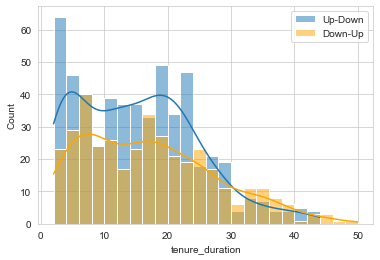

In [60]:
g1 = tenure_bm2_hc_first_time[(tenure_bm2_hc_first_time['h_r_du']==1)]
g2 = tenure_bm2_hc_first_time[(tenure_bm2_hc_first_time['h_r_ud']==1)]
sns.histplot(g2['tenure_duration'], label='Up-Down', binwidth=2, kde=True)
sns.histplot(g1['tenure_duration'], color='orange', label='Down-Up', binwidth = 2, kde=True)


plt.legend()
plt.savefig('../Figures/Movement-frequency-zigzag.pdf')

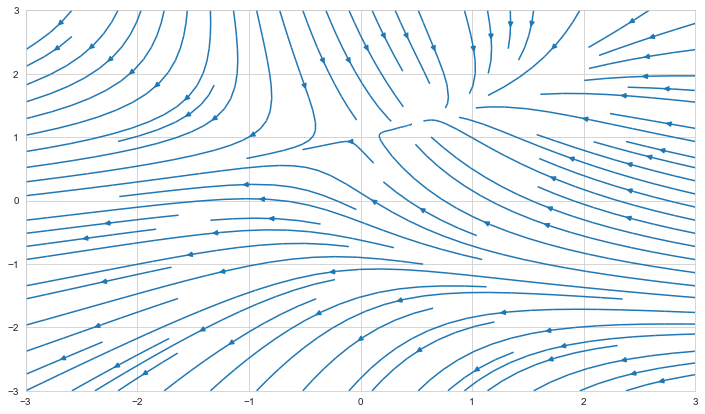

In [62]:

import numpy as np 
import matplotlib.pyplot as plt 
  
# Creating data set 
w = 3
Y, X = np.mgrid[-w:w:100j, -w:w:100j] 
U = -1 - X**2 + Y 
V = 1 + X - Y**2
speed = np.sqrt(U**2 + V**2) 
  
# Creating plot 
fig = plt.figure(figsize = (12, 7)) 
plt.streamplot(X, Y, U, V, density = 1) 
  
# show plot 
plt.show() 

In [64]:
print(Y)

[[-3.         -3.         -3.         ... -3.         -3.
  -3.        ]
 [-2.93939394 -2.93939394 -2.93939394 ... -2.93939394 -2.93939394
  -2.93939394]
 [-2.87878788 -2.87878788 -2.87878788 ... -2.87878788 -2.87878788
  -2.87878788]
 ...
 [ 2.87878788  2.87878788  2.87878788 ...  2.87878788  2.87878788
   2.87878788]
 [ 2.93939394  2.93939394  2.93939394 ...  2.93939394  2.93939394
   2.93939394]
 [ 3.          3.          3.         ...  3.          3.
   3.        ]]


In [34]:
# #Scatter plot movements and tenure first HC FBS
# df_movement = tenure_bm2[tenure_bm2["first_fbs_hc"]==1]
# g_ud = sns.lmplot(x = "h_r_ud_percent", y = "tenure_duration", data = df_movement)
# g_ud.set(ylabel='Number of year when becoming HC at FBS team for the first time', xlabel='Percentage Up-Down Movement')
# plt.savefig('../Figures/up-down-tenure-to-become-hc-fbs.pdf')

In [35]:
# #Scatter plot movements and tenure first HC FBS
# g_uu = sns.lmplot(x = "h_r_uu_percent", y = "tenure_duration", data = df_movement)
# g_uu.set(ylabel='Number of year when becoming HC at FBS team for the first time', xlabel='Percentage Up-Up Movement')
# plt.savefig('../Figures/up-up-tenure-to-become-hc-fbs.pdf')

In [36]:
# #Scatter plot movements and tenure first HC FBS
# g_un = sns.lmplot(x = "h_r_un_percent", y = "tenure_duration", data = df_movement)
# g_un.set(ylabel='Number of year when becoming HC at FBS team for the first time', xlabel='Percentage Up-Non Movement')
# plt.savefig('../Figures/up-non-tenure-to-become-hc-fbs.pdf')

In [37]:
# #Scatter plot movements and tenure first HC FBS
# g_dd = sns.lmplot(x = "h_r_dd_percent", y = "tenure_duration", data = df_movement)
# g_dd.set(ylabel='Number of year when becoming HC at FBS team for the first time', xlabel='Percentage Down-Down Movement')
# plt.savefig('../Figures/down-down-tenure-to-become-hc-fbs.pdf')

In [38]:
# #Scatter plot movements and tenure first HC FBS
# g_du = sns.lmplot(x = "h_r_du_percent", y = "tenure_duration", data = df_movement)
# g_du.set(ylabel='Number of year when becoming HC at FBS team for the first time', xlabel='Percentage Down-Up Movement')
# plt.savefig('../Figures/down-up-tenure-to-become-hc-fbs.pdf')

In [39]:
#g = sns.jointplot(x="pos_diff_bm2_neg", y="percentage_elo_gain_bm2", data=team_change, kind="scatter")
#g.ax_joint.axhline(0, color=".5", linestyle="--")
#g.ax_joint.axvline(0, color=".5", linestyle="--")


## Average number of seasons to become HC at FBS

In [40]:
# #Average number of seasons to become HC at FBS
# g1 = tenure_bm2[tenure_bm2["first_fbs_hc"]==1]
# g1_mean = g1["tenure_duration"].mean()

In [41]:
# g1["tenure_duration"].describe()

In [42]:
# #Graph Average number of seasons to become HC at FBS 
# hc = sns.distplot(g1["tenure_duration"])
# plt.axvline(g1_mean, color="coral", linestyle="--")
# hc.set(xlabel='Number of seasons when becoming HC at FBS team for the first time', ylabel='Fraction')
# plt.savefig('../Figures/Average-number-of-seasons-to-become-HC-FBS.pdf')

## Average number of seasons to become HC first time

In [43]:
# hc_first = tenure_bm2[(tenure_bm2["highest_position_code"]==1) & (tenure_bm2["name"]!="Jamey Chadwell") ]
# hc_name = "x"
# hc_first_time = []
# for x in hc_first.itertuples():
#     if x.name != hc_name:
#         hc_first_times = 1
#         hc_name = x.name
#     else: 
#         hc_first_times=0
        
#     hc_first_time.append(hc_first_times)
    
# hc_first["hc_first_time"] = hc_first_time


In [44]:
# #Average number of seasons to become HC first
# g2 = hc_first[hc_first["hc_first_time"]==1]
# g2_mean = g2["tenure_duration"].mean()
# g2["tenure_duration"].describe()

In [45]:
# #Graph Average number of seasons to become HC first
# hc = sns.distplot(g2["tenure_duration"])
# plt.axvline(g2_mean, color="coral", linestyle="--")
# hc.set(xlabel='Number of seasons when becoming HC for the first time', ylabel='Fraction')
# plt.savefig('../Figures/Average-number-of-seasons-to-become-HC-first.pdf')

In [46]:
# hc_first["x_first"] = hc_first["first_fbs_hc"] -hc_first["hc_first_time"]
# len(hc_first[(hc_first["x_first"]==0) & (hc_first["first_fbs_hc"]==1)])

## Separation across tenure durations

In [47]:
# tenure_scatter = (sns.jointplot(y="percentage_elo_gain_bm2", x="tenure_duration", data=team_change, kind="hex")
#                 .set_axis_labels("Tenure Duration", "Percentage Change in Elo When Change Teams"))
# tenure_scatter.ax_joint.axhline(0, color="coral", linestyle="--")
# plt.savefig("../Figures/scatter-elo-change-tenure.pdf")

In [48]:
# tenure_scatter_pos = (sns.jointplot(y="pos_diff_bm2_neg", x="tenure_duration", data=team_change)
#                 .set_axis_labels("Tenure Duration", "Change in Hierarchy When Change Teams"))
# tenure_scatter_pos.ax_joint.axhline(0, color="coral", linestyle="--")
# plt.savefig("../Figures/scatter-hierarchy-change-tenure.pdf")

## Separate sample before becoming FBS head coaches

In [49]:
# before_hc_fbs = []
# sep_name = "x"
# check = 0
# for x in tenure_bm2.itertuples():
#     if x.name != sep_name:
#         if x.first_fbs_hc !=1:
#             before_hc_fbsx = 0
#             check =0
#         else: 
#             before_hc_fbsx = 1
#             check =1
#     elif check == 1:
#         before_hc_fbsx = 1
    
#     elif x.first_fbs_hc ==1:
#         before_hc_fbsx = 1
#         check = 1
#     else:
#         before_hc_fbsx = 0
        
#     sep_name = x.name    
#     before_hc_fbs.append(before_hc_fbsx)
    
# tenure_bm2["before_hc_fbs"] = before_hc_fbs

In [50]:
# tenure_bm2_before_hc_fbs = tenure_bm2[tenure_bm2["before_hc_fbs"]==0]

In [51]:
# team_change_hc_fbs = tenure_bm2[tenure_bm2["new_college_team"]=="x"]

# plt.axhline(5, color="steelblue", linestyle="--")
# plt.axhline(-5, color="steelblue", linestyle="--")
# plt.axhline(0, color="coral", linestyle="--")
# plt.axvline(3.0, color="coral", linestyle="--")
# before_after_hc_fbs = sns.violinplot( y="percentage_elo_gain_bm2", x="pos_diff_bm2_neg",
#                                      data = team_change_hc_fbs, hue="before_hc_fbs", palette = "Set3")

## How HC-to-HC transition?

In [52]:
# team_change_HC_to_HC = team_change[(team_change["highest_position_code"]==1) &
#                                    (team_change["pos_diff_bm2_neg"]==0)]


In [53]:
# g3 = sns.distplot(team_change_HC_to_HC["percentage_elo_gain_bm2"])
# plt.axvline(0, color=".5", linestyle="--")
# g3.set(xlabel='Percentage Elo Changes', ylabel='Fraction')
# plt.savefig('../Figures/hc-to-hc-transition-elo.pdf')

In [54]:
# team_change.head()

In [55]:
# hiplot_team_change = team_change[['highest_position_code','tenure_duration','season_elo_bm2',
#                                   'percentage_elo_gain_bm2','pos_diff_bm2_neg']]

In [56]:
# hiplot_team_change_plot = hip.Experiment.from_dataframe(hiplot_team_change)
# hiplot_team_change_plot.display()

# Export

In [57]:
#Export
tenure_bm2_hc_first_time.to_csv("../../../Final/Tenure_Stata.csv")